### Address "weirdness" in CPN data
* Delta noise corr. opposite direction
* Delta dprime opposite direction
* Delta noise in the dDR space foes oppisite direction
(These all seem to happen more for this data than for the NAT data. Why?)

In [493]:
import sys
sys.path.append('/auto/users/hellerc/code/projects/nat_pupil_ms/')
from path_settings import DPRIME_DIR, PY_FIGURES_DIR2, CACHE_PATH
from global_settings import ALL_SITES, LOWR_SITES, HIGHR_SITES, CPN_SITES
import charlieTools.nat_sounds_ms.decoding as decoding
import load_results as ld
import nems.db as nd
import charlieTools.nat_sounds_ms.preprocessing as nat_preproc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

os.environ["MKL_NUM_THREADS"]="8"

### NOISE CORRELATION RESULTS

In [521]:
#rsc = ld.load_noise_correlation('rsc_ev_pr_rm2_perstim')
rsc = ld.load_noise_correlation('rsc_ev_perstim')

no results found for site: AMT021b, model: rsc_ev_perstim
no results found for site: ARM005e, model: rsc_ev_perstim
no results found for site: CRD005b, model: rsc_ev_perstim
no results found for site: CRD019b, model: rsc_ev_perstim


In [522]:
# keep only CPN sites
sites = CPN_SITES # CPN_SITES

rsc = rsc[rsc.site.isin(sites)]

# remove nans
#na = (~rsc.bp.isna()) & (~rsc.sp.isna())
#rsc = rsc[na]

# add columns for deltas
rsc['delta_gm'] = rsc.gm_bp - rsc.gm_sp
rsc['delta_rsc'] = rsc.sp - rsc.bp

# exclude the low FR pairs
rscg = rsc[(rsc.gm_bp>1) & (rsc.gm_sp>1)]

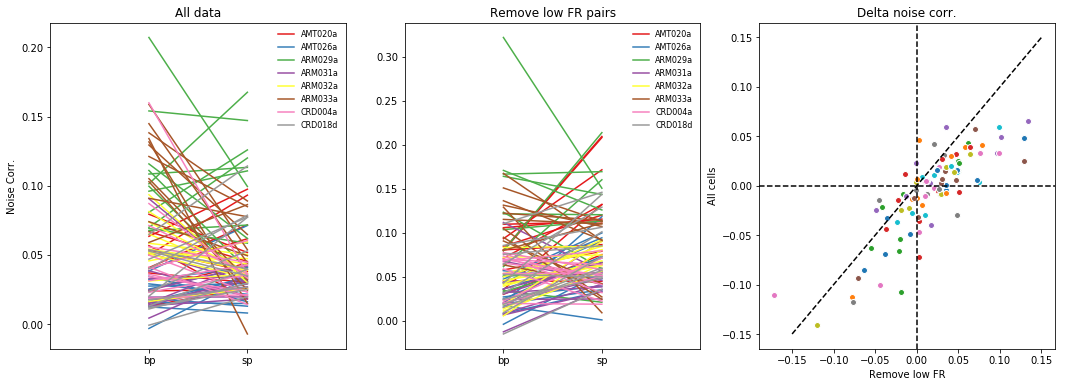

In [523]:
# plot noise correlation before / after removing low FR pairs for all sites
gr = rsc.groupby(by=['site', 'stim']).mean()
grg = rscg.groupby(by=['site', 'stim']).mean()
gr = gr.loc[grg.index]

cmap = plt.cm.get_cmap('Set1', len(rsc.site.unique()))
f, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, s in enumerate(rsc.site.unique()):
    for j, stim in enumerate(gr[gr.index.get_level_values(0)==s].index.get_level_values(1).unique()):
        if j==0:
            lab=s
        else:
            lab=None
        m = (gr.index.get_level_values(0)==s) & (gr.index.get_level_values(1)==stim)
        ax[0].plot([0, 1], [gr[m].bp, gr[m].sp], color=cmap(i), label=lab)

        m = (grg.index.get_level_values(0)==s) & (grg.index.get_level_values(1)==stim)
        ax[1].plot([0, 1], [grg[m].bp, grg[m].sp], color=cmap(i), label=lab)

        ax[2].scatter(grg[m].delta_rsc, gr[m].delta_rsc, label=lab, edgecolor='white')

ax[0].legend(fontsize=8, frameon=False)
ax[1].legend(fontsize=8, frameon=False)
ax[0].set_xticks([0, 1]); ax[0].set_xticklabels(['bp', 'sp'])
ax[1].set_xticks([0, 1]); ax[1].set_xticklabels(['bp', 'sp'])
ax[0].set_ylabel("Noise Corr.")
ax[0].set_title("All data")
ax[1].set_title("Remove low FR pairs")
ax[0].set_xlim((-1, 2))
ax[1].set_xlim((-1, 2))
ax[2].axhline(0, linestyle='--', color='k')
ax[2].axvline(0, linestyle='--', color='k')
ax[2].set_title("Delta noise corr.")
ax[2].set_xlabel("Remove low FR")
ax[2].set_ylabel("All cells")
ax[2].plot([-0.15, 0.15], [-0.15, 0.15], 'k--')

### noise correlations vs. delta noise in dDR space

In [524]:
# load decoding results and append the apprpriate noise correlations to the dataframe.

path = DPRIME_DIR
loader = decoding.DecodingResults()
recache = False
df_all = []
if len(sites) == len(CPN_SITES):
    BATCH = 331
else:
    BATCH = 289
batches = [BATCH]*len(sites)
modelname = 'dprime_pr_rm2_jk10_zscore_nclvz_fixtdr2'
modelname = 'dprime_jk10_zscore_nclvz_fixtdr2'
modelname = 'dprime_jk10_zscore_nclvz_fixtdr2-fa'
#modelname = 'dprime_jk10_zscore_fixtdr2-fa_rmlowFR-4'
ndim = 2

sim = []
for i, (batch, site) in enumerate(zip(batches, sites)):
    if (site in LOWR_SITES) & (batch != 331):
        mn = modelname.replace('_jk10', '_jk1_eev')
    else:
        mn = modelname
    if site in ['BOL005c', 'BOL006b']:
        batch = 294
    try:
        fn = os.path.join(path, str(batch), site, mn+'_TDR.pickle')
        results = loader.load_results(fn, cache_path=None, recache=recache)
        _df = results.numeric_results
    except:
        raise ValueError(f"WARNING!! NOT LOADING SITE {site}")

    stim = results.evoked_stimulus_pairs
    _df = _df.loc[pd.IndexSlice[stim, ndim], :]
    _df['site'] = site
    _df['sp_noise_mag'] = results.array_results['sp_evals'].loc[pd.IndexSlice[stim, ndim], 'mean'].apply(lambda x: x.sum())
    _df['bp_noise_mag'] = results.array_results['bp_evals'].loc[pd.IndexSlice[stim, ndim], 'mean'].apply(lambda x: x.sum())
    _df['noise_alignment'] = results.slice_array_results('cos_dU_evec_test', stim, ndim, idx=(0,0))[0]
    _df['delta_dprime'] = (_df['bp_dp'] - _df['sp_dp']) / (_df['bp_dp'] + _df['sp_dp'])

    # add epoch names back to dataframe
    _df['epoch1'] = [results.mapping[k][0] for k in _df.index.get_level_values(0)]
    _df['epoch2'] = [results.mapping[k][1] for k in _df.index.get_level_values(0)]

    df_all.append(_df)

df = pd.concat(df_all)
df['delta_noise'] = (df['sp_noise_mag'] - df['bp_noise_mag']) / (df['sp_noise_mag'] + df['bp_noise_mag'])

[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT020a/dprime_jk10_zscore_nclvz_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/AMT026a/dprime_jk10_zscore_nclvz_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM029a/dprime_jk10_zscore_nclvz_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM031a/dprime_jk10_zscore_nclvz_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM032a/dprime_jk10_zscore_nclvz_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM033a/dprime_jk10_zscore_nclvz_fixtdr2-fa_TDR.pickle
[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/CRD004a/dprime_jk10_zscore_nclvz_fixtdr2

In [528]:
# merge noise correlation results with decoding results
# Use only the "good" noise correlations
rsc = rscg.copy()
df_merged = df.reset_index()
rg = rsc.groupby(by=['stim', 'site']).mean()
rg.reset_index(inplace=True)

df_merged = df_merged.merge(rg, how='left', left_on=['epoch1', 'site'], right_on=['stim', 'site'], left_index=False, right_index=False, suffixes=('', '_s1'))
df_merged = df_merged.merge(rg, how='left', left_on=['epoch2', 'site'], right_on=['stim', 'site'], left_index=False, right_index=False, suffixes=('', '_s2'))

df['rsc_epoch1_big'] = df_merged['bp'].values
df['rsc_epoch1_small'] = df_merged['sp'].values
df['rsc_epoch2_big'] = df_merged['bp_s2'].values
df['rsc_epoch2_small'] = df_merged['sp_s2'].values
df['rsc_epoch1_delta'] = df_merged['sp'].values - df_merged['bp'].values
df['rsc_epoch2_delta'] = df_merged['sp_s2'].values - df_merged['bp_s2'].values
df['rsc_mean_delta'] = (df['rsc_epoch1_delta'] + df['rsc_epoch2_delta']) / 2


In [530]:
df.keys()

Index(['dp_opt_test', 'dp_diag_test', 'var_explained_test', 'evec_sim_test',
       'dp_opt_train', 'dp_diag_train', 'var_explained_train',
       'evec_sim_train', 'dU_mag_test', 'cos_dU_wopt_test', 'dU_mag_train',
       'cos_dU_wopt_train', 'beta1_dot_dU', 'beta1_dot_tdr2', 'beta1_dot_wopt',
       'beta1_lambda', 'beta1_mag', 'dU_dot_beta1_sq', 'beta1_snr',
       'cos_dU_beta1', 'beta2_dot_dU', 'beta2_dot_tdr2', 'beta2_dot_wopt',
       'beta2_lambda', 'beta2_mag', 'dU_dot_beta2_sq', 'beta2_snr',
       'cos_dU_beta2', 'bp_dp', 'bp_dU_mag', 'bp_cos_dU_wopt', 'sp_dp',
       'sp_dU_mag', 'sp_cos_dU_wopt', 'mean_pupil_range', 'dp_opt_test_sem',
       'dp_diag_test_sem', 'var_explained_test_sem', 'evec_sim_test_sem',
       'dp_opt_train_sem', 'dp_diag_train_sem', 'var_explained_train_sem',
       'evec_sim_train_sem', 'dU_mag_test_sem', 'cos_dU_wopt_test_sem',
       'dU_mag_train_sem', 'cos_dU_wopt_train_sem', 'beta1_dot_dU_sem',
       'beta1_dot_tdr2_sem', 'beta1_dot_wopt_sem', 

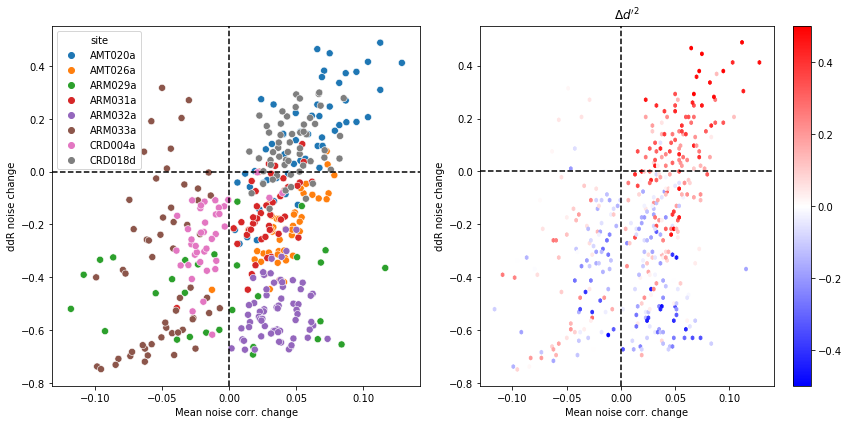

In [552]:
# dDR noise change vs. mean noise correlation change
# **only for stim pairs where both stim's noise corr. change in same direction** to avoid ambiguity
yaxis = 'delta_noise' #'beta2_mag' #'delta_noise'
ylabel ='ddR noise change' # 'noise corr axis projection into dDR space' #'dDR noise change'

if BATCH==289:
    pass#df = df.groupby(by='site').mean()

f, ax = plt.subplots(1, 2, figsize=(12, 6))
mask = ((df['rsc_epoch1_delta']<0) & (df['rsc_epoch2_delta']<0)) | ((df['rsc_epoch1_delta']>0) & (df['rsc_epoch2_delta']>0))
if BATCH == 289:
    rand_sample = np.random.choice(range(df[mask].shape[0]), 1000)
    sns.scatterplot(x='rsc_mean_delta', y=yaxis, data=df[mask].iloc[rand_sample], hue='site', ax=ax[0], **{'s':10})
else:
    sns.scatterplot(x='rsc_mean_delta', y=yaxis, data=df[mask], hue='site', ax=ax[0], **{'s':50})

ax[0].axhline(0, linestyle='--', color='k')
ax[0].axvline(0, linestyle='--', color='k')

ax[0].set_xlabel('Mean noise corr. change')
ax[0].set_ylabel(ylabel)

df[mask].plot.hexbin(
    x='rsc_mean_delta',
    y=yaxis,
    C='delta_dprime',
    cmap='bwr',
    vmin=-0.5,
    vmax=0.5,
    ax=ax[1]
)
ax[1].axhline(0, linestyle='--', color='k')
ax[1].axvline(0, linestyle='--', color='k')
ax[1].set_xlabel('Mean noise corr. change')
ax[1].set_ylabel(ylabel)
ax[1].set_title(r"$\Delta d'^2$")
f.tight_layout()

### Investigate example pairs in the lower right quadrant.
* Why doesn't dDR refelct noise correlation changes?

In [537]:
site = 'ARM032a'
site_mask = df.site==site

example_pairs = df[(df.delta_noise<0) & (df.rsc_mean_delta>0) & site_mask].sort_values(by='rsc_mean_delta', ascending=False)


if 'rmlowFR' in modelname:
    exclude_low_fr = True
    threshold =int(modelname.split('_rmlowFR-')[1].split('_')[0])
else:
    exclude_low_fr = False
    threshold = None
X, sp_bins, X_pup, pup_mask, epochs = decoding.load_site(site=site, batch=331, 
                                       return_epoch_list=True,
                                       exclude_low_fr=exclude_low_fr,
                                       threshold=threshold)
ncells = X.shape[0]
nreps = X.shape[1]
nstim = X.shape[2]
nbins = X.shape[3]
sp_bins = sp_bins.reshape(1, sp_bins.shape[1], nstim * nbins)
nstim = nstim * nbins
nreps = X.shape[1]

# =============================== reshape data ===================================
# reshape mask to match data
pup_mask = pup_mask.reshape(1, nreps, nstim)
# reshape X 
X = X.reshape(ncells, nreps, nstim)
# reshape X_pup
X_pup = X_pup.reshape(1, nreps, nstim)

X_raw = X
X, _ = nat_preproc.scale_est_val([X], [X])
X = X[0]

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/331/ARM032a_75218132cc4bcb10d2dac30e70e4f19b6b0e92f4.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[root INFO] Extracting cellids: ['ARM032a-12-1', 'ARM032a-12-2', 'ARM032a-13-2', 'ARM032a-14-1', 'ARM032a-15-3', 'ARM032a-15-4', 'ARM032a-18-3', 'ARM032a-18-4', 'ARM032a-19-2', 'ARM032a-19-3', 'ARM032a-20-2', 'ARM032a-20-3', 'ARM032a-21-4', 'ARM032a-21-5', 'ARM032a-22-5', 'ARM032a-22-6', 'ARM032a-22-7', 'ARM032a-22-8', 'ARM032a-22-9', 'ARM032a-23-1', 'ARM032a-24-5', 'ARM032a-24-6', 'ARM032a-24-7', 'ARM032a-25-3', 'ARM032a-25-4', 'ARM032a-26-3', 'ARM032a-26-4', 'ARM032a-27-4', 'ARM032a-27-5', 'ARM032a-28-4', 'ARM032a-28-5', 'ARM032a-28-6', 'ARM032a-30-2', 'ARM032a-31-2', 'ARM032a-34-2', 'ARM032a-36-3', 'ARM032a-36-4', 'ARM032a-37-1', 'ARM032a-39-2', 'ARM032a-40-1', 'ARM032a-45-1', 'ARM032a-46-2', 'ARM032a-51-1']


In [541]:
# load data and extract a sample pair of stimuli
ex_pair = 0
e1, e2 = example_pairs['epoch1'].iloc[0], example_pairs['epoch2'].iloc[ex_pair]
idx = example_pairs.index.get_level_values(0)[ex_pair]
i1, i2 = int(idx.split('_')[0]), int(idx.split('_')[1])

In [542]:
# get dDR plane for this site
fn = os.path.join(path, str(batch), site, mn+'_TDR.pickle')
results = loader.load_results(fn, cache_path=None, recache=recache)
dU = results.array_results['dU_all'].loc[pd.IndexSlice[idx, 2]]['mean']
dU /= np.linalg.norm(dU)
evec1 = results.array_results['evecs_all'].loc[pd.IndexSlice[idx, 2]]['mean'][:, 0]
evec1 /= np.linalg.norm(evec1)

# figure out the axis that spans the plane with dU
noise_on_dec = (np.dot(evec1, dU.T)) * dU
orth_ax = evec1 - noise_on_dec
orth_ax /= np.linalg.norm(orth_ax)

weights = np.concatenate((dU, orth_ax), axis=0)

[root INFO] loading pickle from /auto/users/hellerc/results/nat_pupil_ms/dprime_final/331/ARM032a/dprime_jk10_zscore_nclvz_fixtdr2-fa_TDR.pickle


Text(0.5, 0.98, '7_8')

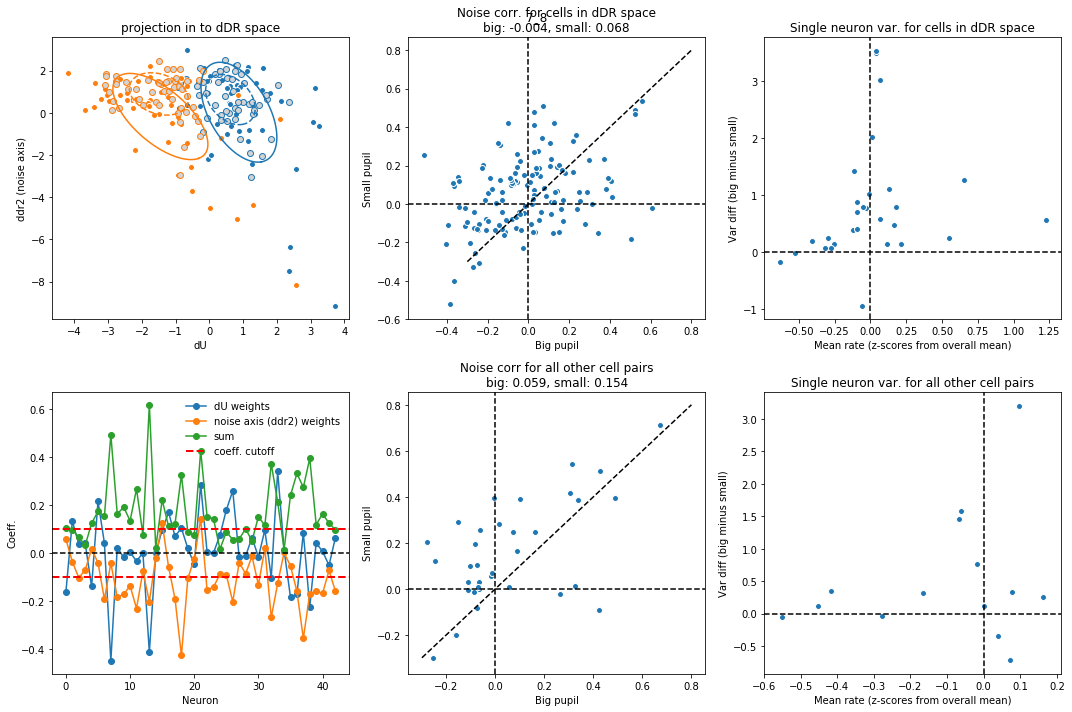

In [543]:
xddr = X[:, :, [i1, i2]].T.dot(weights.T)
bp = X_pup[:, :, [i1, i2]] > np.median(X_pup[:, :, [i1, i2]], axis=(0, 1), keepdims=True)
sp = ~bp
cutoff = 0.1 # cells with dDR coef > cutoff are "included"


from charlieTools.plotting import compute_ellipse
from charlieTools.nat_sounds_ms.decoding import compute_dprime
# plot data in dDR space and show distribution of dDR weights (dominated by single neuron?)
f, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].scatter(xddr[0, bp[0, :, 0], 0], xddr[0, bp[0, :, 0], 1], color='tab:blue', edgecolor='white')
el = compute_ellipse(xddr[0, bp[0, :, 0], 0], xddr[0, bp[0, :, 0], 1])
ax[0, 0].plot(el[0], el[1], color='tab:blue')

ax[0, 0].scatter(xddr[0, sp[0, :, 0], 0], xddr[0, sp[0, :, 0], 1], color='lightgrey', edgecolor='tab:blue')
el = compute_ellipse(xddr[0, sp[0, :, 0], 0], xddr[0, sp[0, :, 0], 1])
ax[0, 0].plot(el[0], el[1], color='tab:blue', linestyle='--')

ax[0, 0].scatter(xddr[1, bp[0, :, 1], 0], xddr[1, bp[0, :, 1], 1], color='tab:orange', edgecolor='white')
el = compute_ellipse(xddr[1, bp[0, :, 1], 0], xddr[1, bp[0, :, 1], 1])
ax[0, 0].plot(el[0], el[1], color='tab:orange')

ax[0, 0].scatter(xddr[1, sp[0, :, 1], 0], xddr[1, sp[0, :, 1], 1], color='lightgrey', edgecolor='tab:orange')
el = compute_ellipse(xddr[1, sp[0, :, 1], 0], xddr[1, sp[0, :, 1], 1])
ax[0, 0].plot(el[0], el[1], color='tab:orange', linestyle='--')
ax[0, 0].set_title("projection in to dDR space")
ax[0, 0].set_xlabel('dU')
ax[0, 0].set_ylabel('ddr2 (noise axis)')

ax[1, 0].plot(weights[0, :], 'o-', label='dU weights')
ax[1, 0].plot(weights[1, :], 'o-', label='noise axis (ddr2) weights')
ax[1, 0].plot(np.abs(np.sum(weights, axis=0)), 'o-', label='sum')
ax[1, 0].axhline(cutoff, linestyle='--', color='red', lw=2, label='coeff. cutoff')
ax[1, 0].axhline(-cutoff, linestyle='--', color='red', lw=2)
ax[1, 0].axhline(0, linestyle='--', color='k')
ax[1, 0].legend(frameon=False)
ax[1, 0].set_xlabel('Neuron')
ax[1, 0].set_ylabel('Coeff.')

# plot noise correlations for these two stimuli for the neurons with big coef, and with small coef (not present in dDR space)
gidx = np.argwhere(np.abs(np.sum(weights, axis=0))>cutoff).squeeze()
bidx = [c for c in range(X.shape[0]) if c not in gidx]
cids_all = np.array([c for c in nd.get_batch_cells(batch).cellid if site in c])
cids_ddr = cids_all[gidx]
cids_rem = np.array([c for c in cids_all if c not in cids_ddr])

_rsc = rsc[(rsc.site==site) & ((rsc.stim==e1) | (rsc.stim==e2))]
ddr_nc = [idx for idx in _rsc.index if (idx.split('_')[0] in cids_ddr) & (idx.split('_')[1] in cids_ddr)]
ddr_nc = _rsc.loc[ddr_nc]
rem_nc = [idx for idx in _rsc.index if (idx.split('_')[0] in cids_rem) & (idx.split('_')[1] in cids_rem)]
rem_nc = _rsc.loc[rem_nc]

ax[0, 1].set_title(f"Noise corr. for cells in dDR space\nbig: {round(ddr_nc.bp.mean(), 3)}, small: {round(ddr_nc.sp.mean(), 3)}")
ax[0, 1].scatter(ddr_nc.bp, ddr_nc.sp, edgecolor='white')
ax[0, 1].set_xlabel('Big pupil')
ax[0, 1].set_ylabel('Small pupil')
ax[0, 1].axhline(0, linestyle='--', color='k'); ax[0, 1].axvline(0, linestyle='--', color='k') 
ax[0, 1].plot([-0.3, 0.8], [-0.3, 0.8], 'k--')

ax[1, 1].set_title(f"Noise corr for all other cell pairs\nbig: {round(rem_nc.bp.mean(), 3)}, small: {round(rem_nc.sp.mean(), 3)}")
ax[1, 1].scatter(rem_nc.bp, rem_nc.sp, edgecolor='white')
ax[1, 1].set_xlabel('Big pupil')
ax[1, 1].set_ylabel('Small pupil')
ax[1, 1].axhline(0, linestyle='--', color='k'); ax[1, 1].axvline(0, linestyle='--', color='k') 
ax[1, 1].plot([-0.3, 0.8], [-0.3, 0.8], 'k--')

# same thing, but for single neuron variance, plot diff as function of mean resp. rate (z-scored)
ddr_var_bp = (X[gidx][:, bp[0,:,0], i1].var(axis=-1) + X[gidx][:, bp[0,:,1], i2].var(axis=-1)) / 2
ddr_var_sp = (X[gidx][:, sp[0,:,0], i1].var(axis=-1) + X[gidx][:, sp[0,:,1], i2].var(axis=-1)) / 2
ddr_var_diff = ddr_var_bp - ddr_var_sp
ddr_mean = X[gidx][:, :, [i1,i2]].mean(axis=(1,2))
rem_var_bp = (X[bidx][:, bp[0,:,0], i1].var(axis=-1) + X[bidx][:, bp[0,:,1], i2].var(axis=-1)) / 2
rem_var_sp = (X[bidx][:, sp[0,:,0], i1].var(axis=-1) + X[bidx][:, sp[0,:,1], i2].var(axis=-1)) / 2
rem_var_diff = rem_var_bp - rem_var_sp
rem_mean = X[bidx][:, :, [i1,i2]].mean(axis=(1,2))
ax[0, 2].set_title(f"Single neuron var. for cells in dDR space")
ax[0, 2].scatter(ddr_mean, ddr_var_diff, edgecolor='white')
ax[0, 2].set_xlabel('Mean rate (z-scores from overall mean)')
ax[0, 2].set_ylabel('Var diff (big minus small)')
ax[0, 2].axhline(0, linestyle='--', color='k'); ax[0, 2].axvline(0, linestyle='--', color='k') 

ax[1, 2].set_title(f"Single neuron var. for all other cell pairs")
ax[1, 2].scatter(rem_mean, rem_var_diff, edgecolor='white')
ax[1, 2].set_xlabel('Mean rate (z-scores from overall mean)')
ax[1, 2].set_ylabel('Var diff (big minus small)')
ax[1, 2].axhline(0, linestyle='--', color='k'); ax[1, 2].axvline(0, linestyle='--', color='k') 


f.tight_layout()

f.suptitle(idx)

In [544]:
# calculated d-prime and verify that it ~matches the dataframe results
print("d-dprime loaded from data frame:")
print(f"Large pupil: {example_pairs.loc[idx, 'bp_dp'].values[0]}")
print(f"Small pupil: {example_pairs.loc[idx, 'sp_dp'].values[0]}")
print(f"Overall: {example_pairs.loc[idx]['dp_opt_train'].values[0]}")
dp, wopt, _, _, _, _= compute_dprime(xddr[0].T, xddr[1].T)
bp_dp, _, _, _, _, _ = compute_dprime(xddr[0, bp[0, :, 0]].T, xddr[1, bp[0, :, 1]].T, wopt=wopt)
sp_dp, _, _, _, _, _ = compute_dprime(xddr[0, sp[0, :, 0]].T, xddr[1, sp[0, :, 1]].T, wopt=wopt)
print("Recomputing d-prime:")
print(f"Large pupil: {bp_dp}")
print(f"Small pupil: {sp_dp}")
print(f"Overall: {dp}")


d-dprime loaded from data frame:
Large pupil: 2.72601580619812
Small pupil: 5.6049699783325195
Overall: 6.683956623077393
Recomputing d-prime:
Large pupil: 5.130865776388181
Small pupil: 7.018967746277456
Overall: 5.750247807653685


### Overall noise space per stimulus
* Plot big / small pupil stimulus-dependent projections onto the overall noise axis

In [550]:
site = 'ARM032a'
batch = 331
X, sp_bins, X_pup, pup_mask, epochs = decoding.load_site(site=site, batch=batch, 
                                       return_epoch_list=True,
                                       exclude_low_fr=True,
                                       threshold=4)
ncells = X.shape[0]
nreps = X.shape[1]
nstim = X.shape[2]
nbins = X.shape[3]
sp_bins = sp_bins.reshape(1, sp_bins.shape[1], nstim * nbins)
nstim = nstim * nbins
nreps = X.shape[1]

# =============================== reshape data ===================================
# reshape mask to match data
pup_mask = pup_mask.reshape(1, nreps, nstim)
# reshape X 
X = X.reshape(ncells, nreps, nstim)
# reshape X_pup
X_pup = X_pup.reshape(1, nreps, nstim)

# normalize data
X_raw = X
X, _ = nat_preproc.scale_est_val([X], [X])
X = X[0]

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/331/ARM032a_75218132cc4bcb10d2dac30e70e4f19b6b0e92f4.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[root INFO] Extracting cellids: ['ARM032a-12-1', 'ARM032a-12-2', 'ARM032a-13-2', 'ARM032a-14-1', 'ARM032a-15-3', 'ARM032a-15-4', 'ARM032a-18-3', 'ARM032a-18-4', 'ARM032a-19-2', 'ARM032a-19-3', 'ARM032a-20-2', 'ARM032a-20-3', 'ARM032a-21-4', 'ARM032a-21-5', 'ARM032a-22-5', 'ARM032a-22-6', 'ARM032a-22-7', 'ARM032a-22-8', 'ARM032a-22-9', 'ARM032a-23-1', 'ARM032a-24-5', 'ARM032a-24-6', 'ARM032a-24-7', 'ARM032a-25-3', 'ARM032a-25-4', 'ARM032a-26-3', 'ARM032a-26-4', 'ARM032a-27-4', 'ARM032a-27-5', 'ARM032a-28-4', 'ARM032a-28-5', 'ARM032a-28-6', 'ARM032a-30-2', 'ARM032a-31-2', 'ARM032a-34-2', 'ARM032a-36-3', 'ARM032a-36-4', 'ARM032a-37-1', 'ARM032a-39-2', 'ARM032a-40-1', 'ARM032a-45-1', 'ARM032a-46-2', 'ARM032a-51-1']
[root INFO] Removing 28 low FR units under threshold of 4Hz


In [569]:
lvs['TAR010c289'].keys()

dict_keys(['beta2', 'beta2_lambda', 'max_var_pc', 'b2_dot_pc1', 'b2_tot_var_ratio', 'b2_var_pc1_ratio', 'shuf_beta2_lambda', 'shuf_beta2_lambda_sd', 'beta2_sig', 'beta1', 'b1_dot_b2', 'b2_corr_gain'])

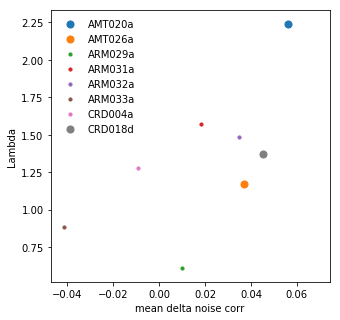

In [568]:
# compare noise correlations with LV magnitude
import pickle
lvs = pickle.load(open('/auto/users/hellerc/results/nat_pupil_ms/LV/nc_zscore_lvs.pickle', 'rb'))
rgrouped = rsc.groupby(by='site').mean()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
# plot sig units first
for site in rgrouped.index:
    b=rgrouped.loc[site]['batch']
    d=lvs[f'{site}{batch}']['beta2_lambda']
    if lvs[f'{site}{batch}']['beta2_sig']:
        ax.scatter(rgrouped.loc[site]['delta_rsc'], d, label=site, s=50)
    else:
        ax.scatter(rgrouped.loc[site]['delta_rsc'], d, label=site, s=10)

ax.set_xlabel('mean delta noise corr')
ax.set_ylabel('Lambda')
ax.legend(frameon=False)

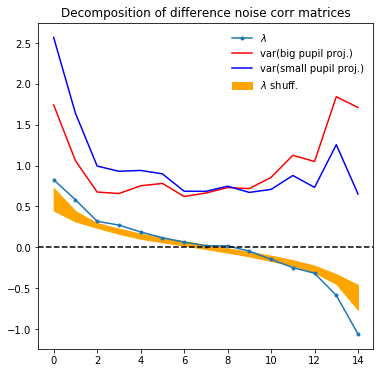

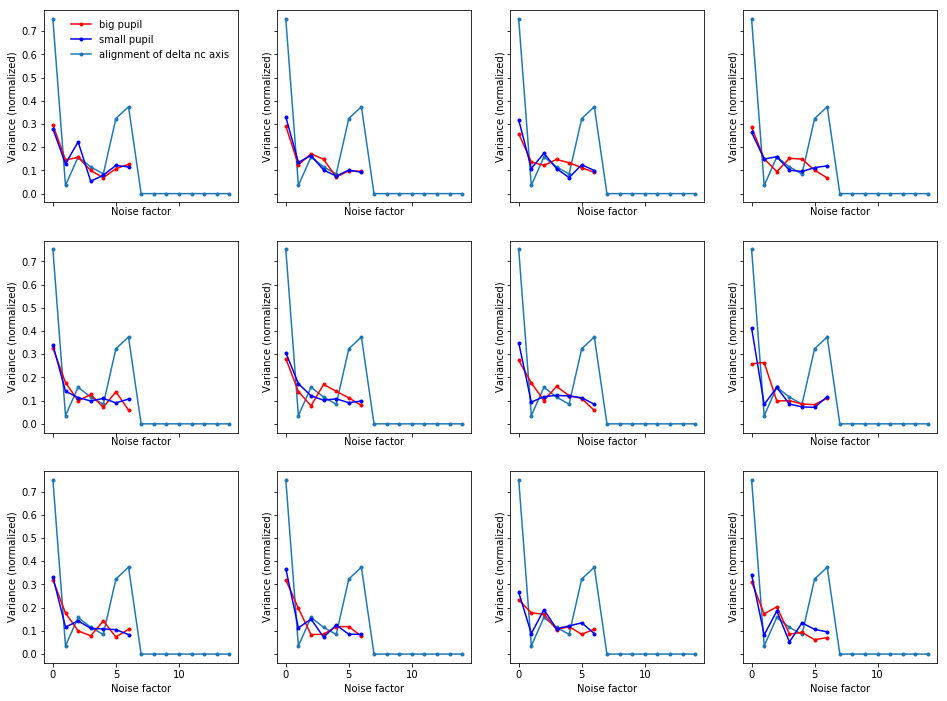

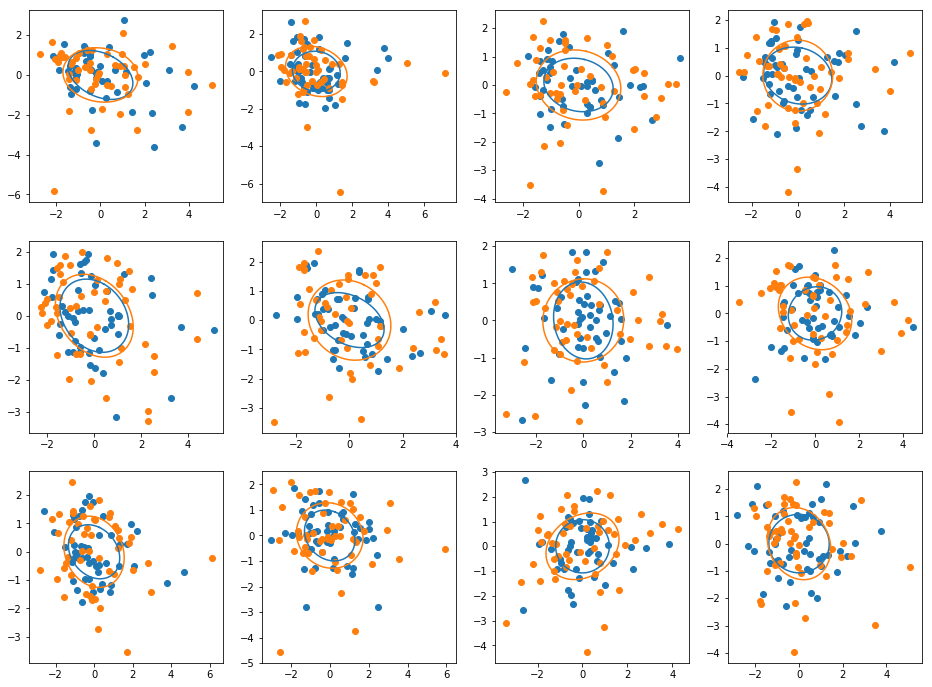

In [551]:
factor_analysis = True
zscore_within_condition = True


from sklearn.decomposition import FactorAnalysis, PCA
# get noise axis (with FA)
residual = X - X.mean(axis=1, keepdims=True)
sd = residual.std(axis=1, keepdims=True)
sd[sd==0] = 1
residual = residual / sd
noise_corr = np.corrcoef(residual.reshape(residual.shape[0], -1))
if factor_analysis:
    fa = FactorAnalysis(n_components=residual.shape[0], random_state=0)
    fa.fit(residual.reshape(residual.shape[0], -1).T)
else:
    fa = PCA(n_components=residual.shape[0])
    fa.fit(residual.reshape(residual.shape[0], -1).T)
norm = np.linalg.norm(fa.components_, axis=1)
norm[norm==0] = 1
factors = (fa.components_.T / norm).T

# get delta noise correlation axis
# zscore responses per stimulus, within pupil condition
bpr = np.stack([X[:, pup_mask[0, :, i], i] for i in range(pup_mask.shape[-1])]).transpose([1, 2, 0])
spr = np.stack([X[:, ~pup_mask[0, :, i], i] for i in range(pup_mask.shape[-1])]).transpose([1, 2, 0])

res_ps_bp = bpr - bpr.mean(axis=1, keepdims=True)
sd = bpr.std(axis=1, keepdims=True)
sd[sd==0] = 1
res_ps_bp /= sd

res_ps_sp = spr - spr.mean(axis=1, keepdims=True)
sd = spr.std(axis=1, keepdims=True)
sd[sd==0] = 1
res_ps_sp /= sd

diff = np.cov(res_ps_sp.reshape(X.shape[0], -1)) - np.cov(res_ps_bp.reshape(X.shape[0], -1))
evals, evecs = np.linalg.eig(diff)
evecs = evecs[:, np.argsort(evals)[::-1]]
evals = evals[np.argsort(evals)[::-1]]

# get shuffled distro of lambdas
shuf_evals = []
for i in range(0, 100):
    bpmask = np.random.choice(range(X.shape[1]), int(X.shape[1]/2))
    spmask = np.array(list(set(range(X.shape[1])).difference(set(bpmask))))
 
    bpr = X[:, bpmask, :]
    spr = X[:, spmask, :]
    _res_ps_bp = bpr - bpr.mean(axis=1, keepdims=True)
    sd = bpr.std(axis=1, keepdims=True)
    sd[sd==0] = 1
    _res_ps_bp /= sd

    _res_ps_sp = spr - spr.mean(axis=1, keepdims=True)
    sd = spr.std(axis=1, keepdims=True)
    sd[sd==0] = 1
    _res_ps_sp /= sd

    diff = np.cov(_res_ps_sp.reshape(X.shape[0], -1)) - np.cov(_res_ps_bp.reshape(X.shape[0], -1))
    #plt.figure()
    #plt.imshow(np.concatenate((np.cov(_res_ps_sp.reshape(X.shape[0], -1)), np.cov(_res_ps_bp.reshape(X.shape[0], -1))), axis=1), vmax=1, vmin=-1)
    sevals, sevecs = np.linalg.eig(diff)
    sevecs = sevecs[:, np.argsort(sevals)[::-1]]
    sevals = sevals[np.argsort(sevals)[::-1]]
    shuf_evals.append(sevals)

delta_axis = evecs[:, 0]

f, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot eigenvalues themselves
ax.plot(evals, '.-', label=r'$\lambda$')
sev = np.stack(shuf_evals)
ax.fill_between(range(len(evals)), sev.mean(axis=0)+sev.std(axis=0), sev.mean(axis=0)-sev.std(axis=0), color='orange', label=r'$\lambda$ shuff.')
ax.axhline(0, linestyle='--', color='k')

# plot variance of projection of data onto the eigenvectors, how does it compare to the delta eigenvalues?
bpp = res_ps_bp.reshape(X.shape[0], -1).T.dot(evecs).var(axis=0)
spp = res_ps_sp.reshape(X.shape[0], -1).T.dot(evecs).var(axis=0)
ax.plot(bpp, color='r', label='var(big pupil proj.)')
ax.plot(spp, color='b', label='var(small pupil proj.)')
ax.legend(frameon=False)
ax.set_title("Decomposition of difference noise corr matrices")

# for each unique stimulus, project large/small pupil data onto these axes
f, ax = plt.subplots(3, 4, figsize=(16, 12), sharex=True, sharey=True)
f2, ax2 = plt.subplots(3, 4, figsize=(16, 12))
for i, (s, a, a2) in enumerate(zip(range(residual.shape[-1]), ax.flatten(), ax2.flatten())):
    bp = residual[:, pup_mask[0, :, s], s]
    sp =  residual[:, ~pup_mask[0, :, s], s]

    if zscore_within_condition:
        bp -= bp.mean(axis=1, keepdims=True)
        sd = bp.std(axis=1, keepdims=True); sd[sd==0] = 1
        bp /= sd
        sp -= sp.mean(axis=1, keepdims=True)
        sd = sp.std(axis=1, keepdims=True); sd[sd==0] = 1
        sp /= sd

    bpvar = (bp).T.dot(factors.T).var(axis=0) / sum(bp.T.dot(factors.T).var(axis=0))
    spvar = (sp).T.dot(factors.T).var(axis=0) / sum(sp.T.dot(factors.T).var(axis=0))
    a.plot(bpvar[np.linalg.norm(factors, axis=1)>0], '.-', color='red', label='big pupil')
    a.plot(spvar[np.linalg.norm(factors, axis=1)>0], '.-', color='blue', label='small pupil')
    a.set_xlabel('Noise factor')
    a.set_ylabel('Variance (normalized)')
    # plot the projection of delta noise corr. axis onto each dim
    a.plot(np.abs(delta_axis.dot(factors.T)), '.-', label='alignment of delta nc axis', zorder=-1)

    weights = evecs[:, 0:2].T #evecs[:, 0:2].T #factors[0:2, :]
    a2.scatter(bp.T.dot(weights[0, :].T), bp.T.dot(weights[1, :].T))
    el = compute_ellipse(bp.T.dot(weights[0, :].T), bp.T.dot(weights[1, :].T))
    a2.plot(el[0], el[1], color='tab:blue')
    a2.scatter(sp.T.dot(weights[0, :].T), sp.T.dot(weights[1, :].T))
    el = compute_ellipse(sp.T.dot(weights[0, :].T), sp.T.dot(weights[1, :].T))
    a2.plot(el[0], el[1], color='tab:orange')

    if i==0:
        a.legend(frameon=False)
